In [1]:
import numpy as np

from helper_functions_tsp import read_file_name, validate_distance_array
from helper_functions_tsp import find_problem_size, cost_fn_fact
from helper_functions_tsp import read_index, hot_start
from helper_functions_tsp import convert_bit_string_to_cycle
from helper_functions_tsp import hot_start_list_to_string, update_paramaters_using_gradient

from helper_functions_tsp import define_parameters, create_initial_rotations
from helper_functions_tsp import bind_weights, vqc_circuit, my_gradient, cost_func_evaluate

from graph_functions import parameter_graph, cost_graph, param_cost_graph

In [2]:
CONTROL_FILE = 'control/control_parameters.csv'
ENCODING = 'utf-8-sig'        #Encoding of csv file
GRAPH_DIRECTORY = 'graphs/'
LOCATIONS = 5                 #number of locations to be visited

SHOTS = 1024                  #shots used for each call of the quantum circuit
S = 0.5                       #parameter for parameter shift.  Default is 0.5
AVERAGE_SLICE = 0.15          #controls the amount of data to be included in the average.  
                              #Default  = 1 - all data
                              #For example, 0.2 means that the lowest 20% is included in the average.
MODE = 2                      # MODE = 1 - rxgate, rygate, cnot gates
                              # MODE = 2 - rxgate, XX gates -can be used with Hot Start
ETA = 0.02                    #eta - learning rate for parameter shift
ITERATIONS = 200              #updates, or iterations
PRINT_FREQUENCY = 20          #how often results are printed out
GRAY = True                   #Use Gray codes
HOT_START = True              #Make a hot start
VERBOSE = False               #controls how much is printedx
#SPSA = False                 #SPSA stochastic gradient descent used

## Read in the control file
The executions are controlled by a CSV parameter file in the control directory

In [3]:
control_dict = read_index(CONTROL_FILE, ENCODING)
print(control_dict)

{0: {'id': '0', 'locations': '5', 'mode': '1', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}, 1: {'id': '1', 'locations': '5', 'mode': '2', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}}


From the number of locations visited find the qubits and longest binary string.

In [4]:
bin_len, qubits = find_problem_size(LOCATIONS)
print(f'There are {qubits} qubits needed.  The longest binary string is {bin_len}')

There are 5 qubits needed.  The longest binary string is 2


Data sources are held locally to avoid downstream dependencies.

In [5]:
data_sources = {  4 : {'file' : 'data/four_d.txt', 'best' : 21},
                  5 : {'file' : 'data/five_d.txt', 'best' : 19},
                 11 : {'file' : 'data/dg11_d.txt', 'best' : 253},
                 15 : {'file' : 'data/p01_d.txt',  'best' : 291},
                 17 : {'file' : 'data/gr17_d.txt', 'best' : 2085},
                 26 : {'file' : 'data/fri26_d.txt', 'best' : 699},
                 42 : {'file' : 'data/dantzig42_d.txt', 'best' : 33_523},
                }

Read the data, and print out the filename and best distance held in the data.

In [6]:
filename = read_file_name(LOCATIONS, data_sources)
best_dist = data_sources[LOCATIONS]['best']
print(f'Data will be read from filename {filename}.  It is known that the shortest distance is {best_dist}.')

Data will be read from filename data/five_d.txt.  It is known that the shortest distance is 19.


Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [7]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

Define the VQC circuits with appropriate parameters, and draw the circuit.

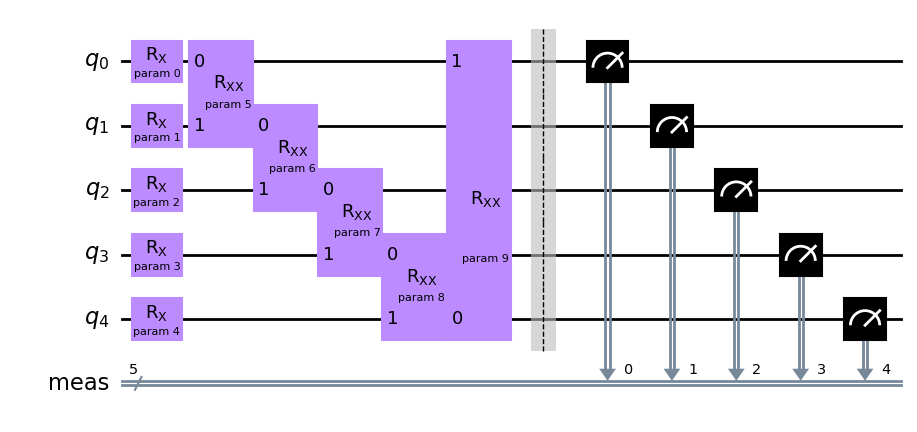

In [8]:
params = define_parameters(qubits, MODE)
qc = vqc_circuit(qubits, params, MODE)
qc.draw("mpl", style="clifford")

Iterate over the control parameters and do one experiment for each one of them.

Create random initial rotations, and bind these to the parameters in a new circuit `bc`.

The hot start location list is [0, 3, 2, 1, 4]
This is equivalent to a binary list: [1, 1, 0, 1, 0]
The hot start distance is 21.0, compared to a best distance of 19.
The initial parameters (weights) are [0, 3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 0, 0, 0, 0]


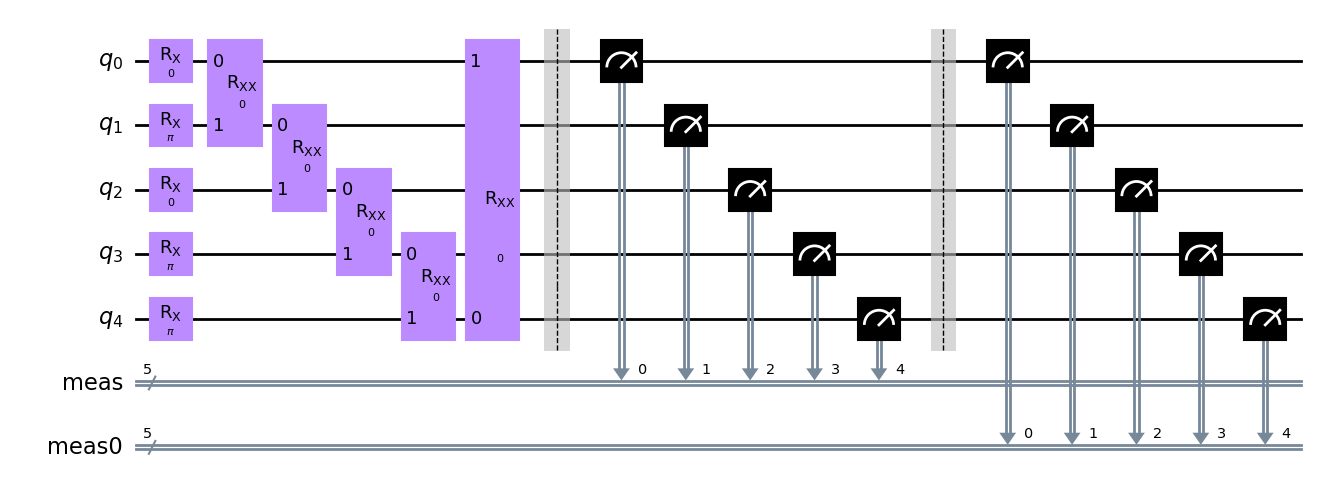

In [9]:
if HOT_START:
    hot_start_list = hot_start(distance_array, LOCATIONS)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY)
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    cost_fn = cost_fn_fact(LOCATIONS,distance_array, GRAY)
    distance = cost_fn(bin_hot_start_list)
    print(f'The hot start distance is {distance}, compared to a best distance of {best_dist}.')
    init_rots = create_initial_rotations(qubits, MODE, bin_hot_start_list, HOT_START)
else:
    init_rots = create_initial_rotations(qubits, MODE)
print(f'The initial parameters (weights) are {init_rots}')
bc = bind_weights(params, init_rots, qc)
bc.measure_all()
bc.draw("mpl", style="clifford")

In [10]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array, gray=GRAY, verbose=VERBOSE)
cost_start, lowest_to_date, _ = cost_func_evaluate(cost_fn, bc, shots=SHOTS, average_slice=AVERAGE_SLICE, verbose=VERBOSE)
print(f'For the starting circuit the average cost is {cost_start:.1f} and the lowest cost is {lowest_to_date:.1f}')

For the starting circuit the average cost is 21.0 and the lowest cost is 21.0


Next we test the impact of varying each parameter in turn on the average cost.

In [11]:
number_of_values = 100
param_values = [(i * 2 * np.pi) / number_of_values for i in range(number_of_values)]

c:\Users\DanielGoldsmith\python notebooks\TSP_VQC\graph_functions.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


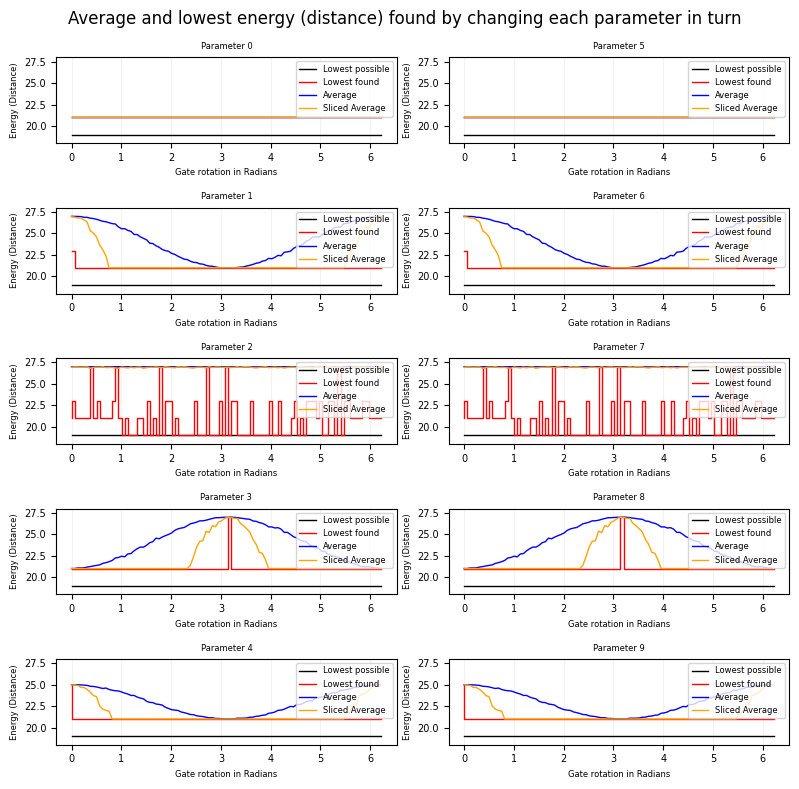

In [12]:
cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
for i in range(2*qubits):
    if VERBOSE:
        print(f'Processing parameter {i}')
    rots = init_rots
    cost_list, lowest_list, sliced_cost_list  = [], [], []
    for j, angle in enumerate(param_values):
        rots[i] = angle
        bc = bind_weights(params, rots, qc)
        sliced_cost, _ , _ = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice=AVERAGE_SLICE, verbose=VERBOSE)
        cost, lowest, lowest_energy_bit_string = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice=1, verbose=VERBOSE)
        route_list = convert_bit_string_to_cycle(lowest_energy_bit_string, LOCATIONS, gray=GRAY)
        cost_list.append(cost)
        lowest_list.append(lowest)
        sliced_cost_list.append(sliced_cost)
        if VERBOSE:
            print(f'For angle {angle} the cost is {cost}, the lowest cost found is {lowest}')
            print(f'the lowest energy bit string is {lowest_energy_bit_string} and this corresponds to a route of {route_list}')
            print(f'The average is {cost} without slicing, and {sliced_cost} with slicing')
    cost_list_all.append(cost_list)
    lowest_list_all.append(lowest_list)     
    sliced_cost_list_all.append(sliced_cost_list)

filename = GRAPH_DIRECTORY + 'Parameter_values'
param_cost_graph(filename, param_values, cost_list_all, lowest_list_all, sliced_cost_list_all, best_dist)

In [ ]:
rots = init_rots
index_l, cost_l, lowest_, gradient_l = update_paramaters_using_gradient(locations=LOCATIONS, iterations=ITERATIONS, 
                                                                    print_frequency=PRINT_FREQUENCY, params=params,
                                                                    rots=rots,  
                                                                    cost_fn=cost_fn, qc = qc, shots=SHOTS, s=S, 
                                                                    eta=ETA, average_slice=AVERAGE_SLICE, gray=GRAY, 
                                                                    verbose=True)

UnboundLocalError: cannot access local variable 'rots' where it is not associated with a value

In [ ]:
legend = [params[i].name for i in range(len(params))] 
filename = GRAPH_DIRECTORY+f'Test'
parameter_graph(filename, index_l, gradient_l, legend)

In [ ]:
title = f'Average distance and lowest distance'
filename = GRAPH_DIRECTORY+title
cost_graph(filename, index_l, cost_l, lowest_l, title)

In [ ]:
rots = init_rots
cost_list, lowest_list, index_list, gradient_list = [], [], [], []
for i in range(ITERATIONS):
    bc = bind_weights(params, rots, qc)
    cost, lowest, lowest_energy_bit_string = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice = AVERAGE_SLICE, verbose=VERBOSE)
    if VERBOSE:
        print(f'cost, lowest, lowest_energy_bit_string = {cost}, {lowest}, {lowest_energy_bit_string}')
    if i == 0:
        lowest_string_to_date = lowest_energy_bit_string
        lowest_to_date = lowest
    else:
        if VERBOSE:
            print(f'lowest,  lowest_to_date {lowest}, {lowest_to_date}')
        if lowest < lowest_to_date:
            if VERBOSE:
                print('Lowest less than lowest to date')
            lowest_to_date = lowest
            lowest_string_to_date = lowest_energy_bit_string
            if VERBOSE:
                print(f'lowest,  lowest_to_date {lowest}, {lowest_to_date}')
    route_list = convert_bit_string_to_cycle(lowest_string_to_date, LOCATIONS, gray=GRAY)
    index_list.append(i)
    cost_list.append(cost)
    lowest_list.append(lowest_to_date)
    gradient = np.array(my_gradient(cost_fn, qc, params, rots, S, SHOTS))
    gradient_list.append(gradient)
    if i % PRINT_FREQUENCY == 0:
        print(f'For iteration {i} the average cost from the sample is {cost} and the lowest cost from the sample is {lowest}')
        print(f'The lowest cost to date is {lowest_to_date} corresponding to bit string {lowest_string_to_date} ')
        print(f'and route {route_list}')
        if VERBOSE:
            print(f'The gradient is {gradient}')
    rots = rots - ETA * gradient

For iteration 0 the average cost from the sample is 24.908854166666668 and the lowest cost from the sample is 21.0
The lowest cost to date is 21.0 corresponding to bit string [1, 0, 0, 0, 0] 
and route [0, 4, 1, 2, 3]
For iteration 20 the average cost from the sample is 24.9609375 and the lowest cost from the sample is 21.0
The lowest cost to date is 21.0 corresponding to bit string [1, 0, 0, 0, 0] 
and route [0, 4, 1, 2, 3]
For iteration 40 the average cost from the sample is 24.713541666666668 and the lowest cost from the sample is 21.0
The lowest cost to date is 21.0 corresponding to bit string [1, 0, 0, 0, 0] 
and route [0, 4, 1, 2, 3]
For iteration 60 the average cost from the sample is 24.309895833333336 and the lowest cost from the sample is 21.0
The lowest cost to date is 19.0 corresponding to bit string [0, 1, 1, 0, 1] 
and route [0, 2, 1, 4, 3]
For iteration 80 the average cost from the sample is 23.9453125 and the lowest cost from the sample is 21.0
The lowest cost to date i

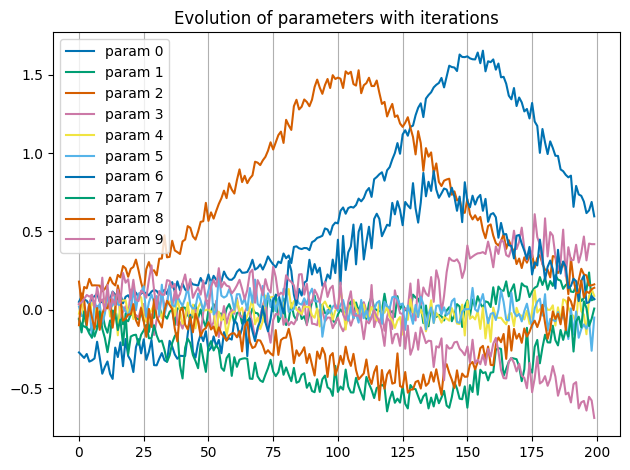

In [ ]:
#legend = [params[i].name for i, param in enumerate(params)] 
legend = [params[i].name for i in range(len(params))] 
filename = GRAPH_DIRECTORY+f'Test'
parameter_graph(filename, index_list, gradient_list, legend)


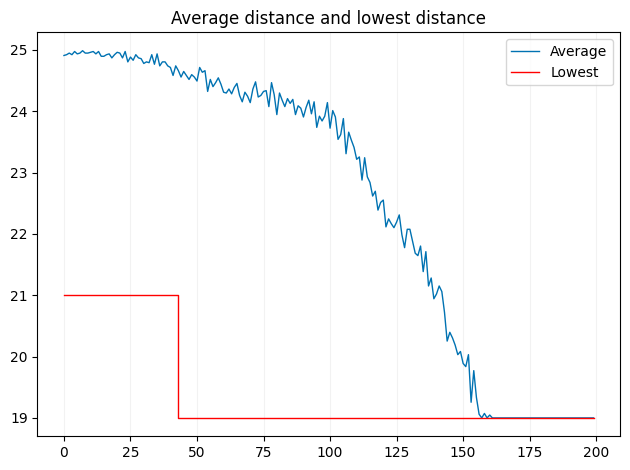

In [ ]:
title = f'Average distance and lowest distance'
filename = GRAPH_DIRECTORY+title
cost_graph(filename, index_list, cost_list, lowest_list, title)